In [2]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## OOP （面向对象） API

这一节记录一些用于 jupyter notebook 面向对象编程的 API。

### 添加属性 / 方法

允许我们将函数添加进一个类作为方法。

可以将 `class` 的定义拆散成小块。

In [3]:
def add_to_class(Class):
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [4]:
class Cat:
    def __init__(self, cat_name: str):
        self.name = cat_name
        self.age = 0
    
    def grow(self):
        self.age += 1
    
    def __repr__(self):
        return "Cat {}, age {}".format(self.name, self.age)

neko = Cat('Neko')
neko.grow()
neko

Cat Neko, age 1

定义函数并将函数添加到类中，相当于：

```python
add_to_cat = add_to_class(Cat)
self_introduction = add_to_cat(self_introduction)
```

In [5]:
@add_to_class(Cat)
def self_introduction(self) -> None:
    print("Hello! My name is {} nya~ I am {} years old nya~".format(self.name, self.age))

# 定义完成后，self_introduction 变为 wrapper 的返回值，即 None
self_introduction, neko.self_introduction()

Hello! My name is Neko nya~ I am 1 years old nya~


(None, None)

### 保存超参数

方法：调用栈，查看栈内的局部变量，将局部变量写为类的属性

该方法可以将 `__init__` 函数传入的形参（本地变量）全都保存为类的属性

In [6]:
import inspect

class HyperParameters:
    def save_hyperparameters(self, ignore=[]):
        # currentframe 获得栈帧
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame) # 获得所有本地变量
        self.hparams = {
            k: v for k, v in local_vars.items()
            if k not in set(ignore + ['self']) and not k.startswith('_')
        } # 过滤 self 变量、下划线开头变量
        for k, v in self.hparams.items():
            setattr(self, k, v)

In [7]:
class B(HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c']) # 将 a, b 保存为属性，不包括 c

b = B(a=1, b='qwq', c=3)
b.a, b.b, hasattr(b, 'c')

(1, 'qwq', False)

### 动态绘图

可以根据输出结果实时绘图（慎用，占用内存较大）

In [8]:
import collections
from matplotlib_inline import backend_inline
import matplotlib.pyplot as plt
from IPython import display

class ProgressBoard(HyperParameters):
    def __init__(
        self, xlabel=None, ylabel=None, xlim=None, ylim=None,
        xscale='linear', yscale='linear',
        ls=['-', '--', '-.', ':'],
        colors=['C0', 'C1', 'C2', 'C3'],
        fig=None, axes=None, figsize=(3.5, 2.5), display=True
    ):
        self.save_hyperparameters()
    
    def draw(self, x, y, label, every_n=1):
        Point = collections.namedtuple('Point', ['x', 'y']) # 创建命名元组
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict() # 有序映射
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = [] # 空列表
            self.data[label] = []
        points: list = self.raw_points[label]
        line: list = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(
            mean([p.x for p in points]),
            mean([p.y for p in points])
        ))
        points.clear()
        if not self.display:
            return
        backend_inline.set_matplotlib_formats('svg') # 设置矢量图格式
        if self.fig is None:
            self.fig = plt.figure(figsize=self.figsize) # 创建画布
        plt_lines, labels = [], []
        for (k, v), ls ,color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(plt.plot(
                [p.x for p in v], [p.y for p in v],
                linestyle=ls, color=color
            )[0])
            labels.append(k)
        axes = self.axes if self.axes else plt.gca() # get current axes 获得当前子图
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels) # 设置图例
        display.display(self.fig) # 显示图像
        display.clear_output(wait=True) # 让新显示的图覆盖原图

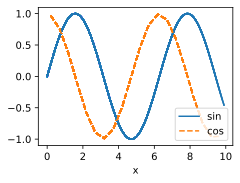

In [9]:
# board = ProgressBoard('x')
# for x in np.arange(0, 10, 0.1):
#     board.draw(x, np.sin(x), 'sin')
#     board.draw(x, np.cos(x), 'cos', 5)

### 模型基类

使用 `Module` 来存储模型的基类，它会继承 `nn.Module` 基类

In [10]:
class Module(nn.Module, d2l.HyperParameters):
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1): # 存储参数
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X): # 前向计算函数，会被 nn.Module 自动调用
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train): # 绘图
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch): # 训练
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError


`nn.Module` 中定义的前向函数 `forward` 可以被自动调用，使实例成为一个 callable 对象

In [14]:
class exp(nn.Module):
    def __init__(self, base):
        super().__init__()
        self.base = base

    def forward(self, x):
        return self.base ** x

exp2 = exp(2)
exp2(4)

16

### 数据基类

用于处理数据。

`train_dataloader` 用于返回一个数据的迭代器，按照一定的 batch 产生数据。

In [ ]:
class DataModule(HyperParameters):  #@save
    def __init__(self, root='../data', num_workers=1):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)


### 优化器基类

最核心的方法是 `fit`，用于训练网络（更新参数）。接受两个参数：`model` 和 `data`，分别是以上两个类的实例。

In [ ]:
class Trainer():
    def __init__(self, max_epochs: int, num_gpus=0, gradient_clip_val=0):
        self.max_epochs = max_epochs
        self.num_gpus = num_gpus
        self.gradient_clip_val = gradient_clip_val
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data: DataModule):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model: Module):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model: Module, data: DataModule):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError
